# Decision Tree Classification

_Assignment for the University of Bath as part of MSc in Artificial Intelligence_ 

_Data Sources:_

_weather-data - University of Bath department of Computer Science_

_heart-prediction - https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset_

### 1. Tree implementation

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sn

First several classes are created to represent the leaves and branches of the tree, along with a class which represents a test used to partition the dataset.

In [2]:
class LeafNode:
    
    def __init__(self, dataset, y_column):
        self.output = dataset[y_column].value_counts().idxmax()
        self.confidence = dataset[y_column].value_counts().max() / dataset[y_column].value_counts().sum()

class BranchNode:
    
    def __init__(self, partition_test, match_branch, non_match_branch):
        self.partition_test = partition_test
        self.match_branch = match_branch
        self.non_match_branch = non_match_branch

class PartitionTest:
    
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def __repr__(self):
        if is_discrete(self.column):
            comparison = "=="
        else:
            comparison = "<"
        return f"Is {self.column.name} {comparison} {self.value} ?"

My algorithm uses a CART approach to construct a binary classification tree from a given dataset. There are a couple of implementational choices I made here. The first was to use a binary approach where each test produces a true or false result, this allows for more easily readable trees when the number of possible values of a variable is high, especially when the tree is depth-limited. The second was to use the CART algorithm as opposed to another approach such as ID3. CART is slightly less computationally expensive and performance of both algorithms is comparable.

The following functions are used to partition the dataset, galculate the gini impurity and find the best partition based on the lowest weighted gini impurity for among the different tests.

In [3]:
def is_discrete(column):
    if isinstance(column.iloc[0], (np.int64, np.float64)):
        if column.nunique() >= (len(column) * 0.1):
            return False
        else:
            return True
    else:
        return True

def partition(dataset, partition_test):
    if is_discrete(partition_test.column):
        match_data = dataset[dataset[partition_test.column.name] == partition_test.value]
        non_match_data = dataset[dataset[partition_test.column.name] != partition_test.value]
    else:
        match_data = dataset[dataset[partition_test.column.name] < partition_test.value]
        non_match_data = dataset[dataset[partition_test.column.name] >= partition_test.value]

    return match_data, non_match_data

def current_gini_impurity(dataset, y_column):
    y_counts = dataset[y_column].value_counts()
    gini = 1 - (np.square(y_counts / y_counts.sum())).sum()
    return gini

def weighted_gini_impurity(match_data, non_match_data, y_column):
    y_counts = match_data[y_column].value_counts()
    match_data_gini = 1 - (np.square(y_counts / y_counts.sum())).sum()
    y_counts2 = non_match_data[y_column].value_counts()
    non_match_data_gini = 1 - (np.square(y_counts2 / y_counts2.sum())).sum()
    weighted_gini = (y_counts.sum() * match_data_gini + y_counts2.sum() * non_match_data_gini) / (y_counts.sum() + y_counts2.sum())
    return weighted_gini

def find_best_partition(dataset, y_column):
    best_gini = None
    best_partition_test = None
    for column in dataset:
        if column != y_column:
            if is_discrete(dataset[column]):
                for value in dataset[column].unique():
                    test = PartitionTest(dataset[column], value)
                    match_data, non_match_data = partition(dataset, test)
                    gini = weighted_gini_impurity(match_data, non_match_data, y_column)
                    if best_gini is None or gini < best_gini:
                        best_gini = gini
                        best_partition_test = test
            else:
                sorted_data = dataset.sort_values(by=column)
                arr = np.array(sorted_data[column])
                values = []
                for i in range(len(arr) - 1):
                    values.append((arr[i] + arr[i + 1]) / 2)
                for value in values:
                    test = PartitionTest(dataset[column], value)
                    match_data, non_match_data = partition(dataset, test)
                    gini = weighted_gini_impurity(match_data, non_match_data, y_column)
                    if best_gini is None or gini < best_gini:
                        best_gini = gini
                        best_partition_test = test

    return best_gini, best_partition_test

This approach can handle both discrete (numeric or non-numeric) and continuous input variables, testing whether values are equal to the test variable value when it is discrete, or less than the value when it is continuous. The next two functions below recursively grow and print the tree.

In [4]:
def grow_tree(dataset, y_column, current_depth=0, max_depth=100):
    best_gini, best_test = find_best_partition(dataset, y_column)
    if best_gini is None or best_gini >= current_gini_impurity(dataset, y_column) or current_depth >= max_depth:
        return LeafNode(dataset, y_column)
    match_data, non_match_data = partition(dataset, best_test)
    match_data, non_match_data = match_data.drop(columns=[best_test.column.name]), non_match_data.drop(columns=[best_test.column.name])
    branch1 = grow_tree(match_data, y_column, current_depth + 1, max_depth=max_depth)
    branch2 = grow_tree(non_match_data, y_column, current_depth + 1, max_depth=max_depth)
    return BranchNode(best_test, branch1, branch2)

def print_tree(node, spacing=""):
    if isinstance(node, LeafNode):
        print(spacing + f"Output = {node.output} with confidence {node.confidence}")
        return
    print (spacing + str(node.partition_test))
    print (spacing + '  --> True:')
    print_tree(node.match_branch, spacing + "      ")
    print (spacing + '  --> False:')
    print_tree(node.non_match_branch, spacing + "      ")

### 2. Dataset trees

The trees for the weather data and my chosen dataset (heart attack prediction) are printed below. For the heart attack prediction, I have limited the maximum depth of the tree so as to make it more readable, but this can be changed with the "max_depth" parameter as desired. For each leaf node, the algorithm also returns it's "confidence" which is simply the proportion of the prediction made by the algorithm in the leaf node data. For example, if the leaf node predicts "Yes" and the leaf node contains 4 "Yes" values and 1 "No" value, the confidence will be 4/5 = 0.8.

In [5]:
weather_data = pd.read_csv("C:/Users/samjp/OneDrive/Desktop/Data Science Portfolio/Decision Tree Classification/Data/weather-data.csv")
weather_data = weather_data.drop("Day", axis=1) # removing "Day" column as it is simply an index and not relevant to decisions
tree = grow_tree(weather_data, "Decision")
print_tree(tree)

Is Outlook == Overcast ?
  --> True:
      Output = Yes with confidence 1.0
  --> False:
      Is Humidity == High ?
        --> True:
            Is Temperature == Hot ?
              --> True:
                  Output = No with confidence 1.0
              --> False:
                  Is Wind == Weak ?
                    --> True:
                        Output = Yes with confidence 0.5
                    --> False:
                        Output = No with confidence 1.0
        --> False:
            Is Wind == Weak ?
              --> True:
                  Output = Yes with confidence 1.0
              --> False:
                  Is Temperature == Cool ?
                    --> True:
                        Output = No with confidence 1.0
                    --> False:
                        Output = Yes with confidence 1.0


In [6]:
heart_disease_data = pd.read_csv("C:/Users/samjp/OneDrive/Desktop/Data Science Portfolio/Decision Tree Classification/Data/heart-prediction.csv")
tree = grow_tree(heart_disease_data, "output", max_depth=3)
print_tree(tree)

Is thall == 2 ?
  --> True:
      Is caa == 0 ?
        --> True:
            Is trtbps < 158.0 ?
              --> True:
                  Output = 1 with confidence 0.9174311926605505
              --> False:
                  Output = 0 with confidence 0.6
        --> False:
            Is cp == 0 ?
              --> True:
                  Output = 0 with confidence 0.85
              --> False:
                  Output = 1 with confidence 0.78125
  --> False:
      Is cp == 0 ?
        --> True:
            Is oldpeak < 0.55 ?
              --> True:
                  Output = 0 with confidence 0.6363636363636364
              --> False:
                  Output = 0 with confidence 0.9710144927536232
        --> False:
            Is caa < 0.5 ?
              --> True:
                  Output = 1 with confidence 0.7142857142857143
              --> False:
                  Output = 0 with confidence 0.7222222222222222


### 3. Performance evaluation on heart disease dataset

In order to assess the performance of my algorithm, the functions below split the data into test and train datasets, train the model and compare it's predictions to the true output in the data, outputting overall accuracy and a confusion matrix.

In [7]:
def test_train_split(dataset, fraction=0.1):
    test = dataset.sample(frac=fraction, axis=0, random_state=1)
    train = dataset.drop(index=test.index)

    return test, train

def predict_row_output(row, node):
    if isinstance(node, LeafNode):
        return node.output
    if is_discrete(node.partition_test.column):
        if row[1][node.partition_test.column.name] == node.partition_test.value:
            return predict_row_output(row, node.match_branch)
        else:
            return predict_row_output(row, node.non_match_branch)
    else:
        if row[1][node.partition_test.column.name] < node.partition_test.value:
            return predict_row_output(row, node.match_branch)
        else:
            return predict_row_output(row, node.non_match_branch)

def predict_test_data_output(test_data, node):
    predictions = []
    for row in test_data.iterrows():
        predictions.append(predict_row_output(row, node))
    return predictions

def decision_tree_accuracy(test_data, predictions, y_column):
    comparison = test_data.assign(prediction=predictions)
    comparison["match"] = np.where(comparison[y_column] == comparison["prediction"], True, False)
    return comparison["match"].value_counts()[True] / len(comparison)

In [8]:
test_data, train_data = test_train_split(heart_disease_data)
tree = grow_tree(train_data, "output", max_depth=3)
predictions = predict_test_data_output(test_data, tree)
accuracy = decision_tree_accuracy(test_data, predictions, "output")
print(f"Accuracy = {accuracy}")

Accuracy = 0.8666666666666667


<AxesSubplot:xlabel='prediction', ylabel='output'>

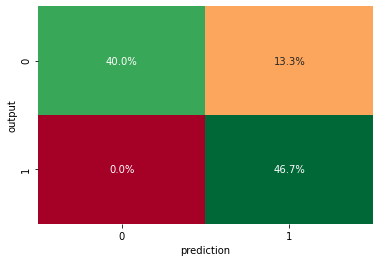

In [9]:
comparison = test_data.assign(prediction=predictions)
confusion_matrix = pd.crosstab(comparison["output"], comparison["prediction"])
sn.heatmap(confusion_matrix/len(test_data), annot=True, fmt=".1%", cbar=False, cmap="RdYlGn")

Finally, the code below runs k-fold cross validation to assess the performance of the algorithm over 10 different test/train splits, to get a better idea of how accurate the algorithm is more generally. The output is the accuracy on each split, along with the average accuracy over all 10.

In [10]:
def cross_validation(dataset, y_column, max_depth=100, k=10):
    accuracy_list = []
    sample_list = [i for i in range(len(dataset))]
    while sample_list != []:
        sample = random.sample(sample_list, min((-(-len(dataset) // k)), len(sample_list)))
        for num in sample:
            sample_list.remove(num)
        test_data = dataset.iloc[sample]
        train_data = dataset.drop(index=test_data.index)
        tree = grow_tree(train_data, y_column, max_depth=max_depth)
        predictions = predict_test_data_output(test_data, tree)
        accuracy_list.append(decision_tree_accuracy(test_data, predictions, y_column))
    average_accuracy = np.mean(accuracy_list)
    return accuracy_list, average_accuracy

In [11]:
random.seed(1)
acc_list, ave_acc = cross_validation(heart_disease_data, "output", max_depth=3)
print(f"Accuracy on each split = {acc_list}")
print(f"Average accuracy = {ave_acc}")

Accuracy on each split = [0.7419354838709677, 0.8064516129032258, 0.967741935483871, 0.7096774193548387, 0.8709677419354839, 0.9032258064516129, 0.7096774193548387, 0.6129032258064516, 0.8064516129032258, 0.875]
Average accuracy = 0.8004032258064516
